--- [0] Installing necessary libraries ---

Libraries installed and imported successfully.

--- [1] Setting up configuration and paths ---
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

--- [2] Defining Modular Pipeline Steps ---

--- [3] Defining Pipeline Orchestrator ---
--- Running Step 0: Ingest & Standardize ---
Loaded 57477 raw records.
-> Remaining records: 57439
Saved checkpoint: /content/drive/MyDrive/JudgeModel/pipeline_checkpoints/0_ingested.parquet
--- Running Step 1: Text Cleaning & Normalization ---


/tmp/ipython-input-16-3599873088.py:99: MarkupResemblesLocatorWarning: The input passed in on this line looks more like a URL than HTML or XML.

If you meant to use Beautiful Soup to parse the web page found at a certain URL, then something has gone wrong. You should use an Python package like 'requests' to fetch the content behind the URL. Once you have the content as a string, you can feed that string into Beautiful Soup.

However, if you want to parse some data that happens to look like a URL, then nothing has gone wrong: you are using Beautiful Soup correctly, and this warning is spurious and can be filtered. To make this warning go away, run this code before calling the BeautifulSoup constructor:

    from bs4 import MarkupResemblesLocatorWarning
    import warnings

    warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning)
    
  try: text = BeautifulSoup(text, "lxml").get_text()
/tmp/ipython-input-16-3599873088.py:99: MarkupResemblesLocatorWarning: The input 

-> Remaining records: 57439
Saved checkpoint: /content/drive/MyDrive/JudgeModel/pipeline_checkpoints/1_cleaned.parquet
--- Running Step 2: Statistical & Heuristic Filtering ---
-> Remaining records: 54191
Saved checkpoint: /content/drive/MyDrive/JudgeModel/pipeline_checkpoints/2_statistical_filtered.parquet
--- Running Step 3: Language & Content Validation ---
-> Remaining records: 45668
Saved checkpoint: /content/drive/MyDrive/JudgeModel/pipeline_checkpoints/3_content_validated.parquet
--- Running Step 4: Semantic Deduplication ---
Finding paraphrases in 45668 prompts...


Batches:   0%|          | 0/1428 [00:00<?, ?it/s]

Filtering 38206 potential pairs with score threshold >= 0.95...
Found 5702 semantic duplicates to remove.
-> Remaining records: 39966
Saved checkpoint: /content/drive/MyDrive/JudgeModel/pipeline_checkpoints/4_deduplicated.parquet

--- [4] Final Validation & Persistence ---
✅ Final validation successful!

Successfully wrote 39966 high-purity records to: /content/drive/MyDrive/JudgeModel/high_purity_golden_datasets/high_purity_golden_data_v_2025-07-05T14-27-23.parquet

--- [5] Generating Report ---

      High-Purity Data Foundation Report
      Overall Data Retention Rate: 69.53%
                       Filtration Stage  Remaining Records  % Dropped from Previous
                 0. Initial Raw Records              57477                    -0.00
          1. After Ingest & Standardize              57439                     0.07
            2. After Text Normalization              57439                    -0.00
         3. After Statistical Filtering              54191                    

/tmp/ipython-input-16-3599873088.py:297: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Remaining Records", y="Filtration Stage", data=report_df, orient='h', palette='viridis')


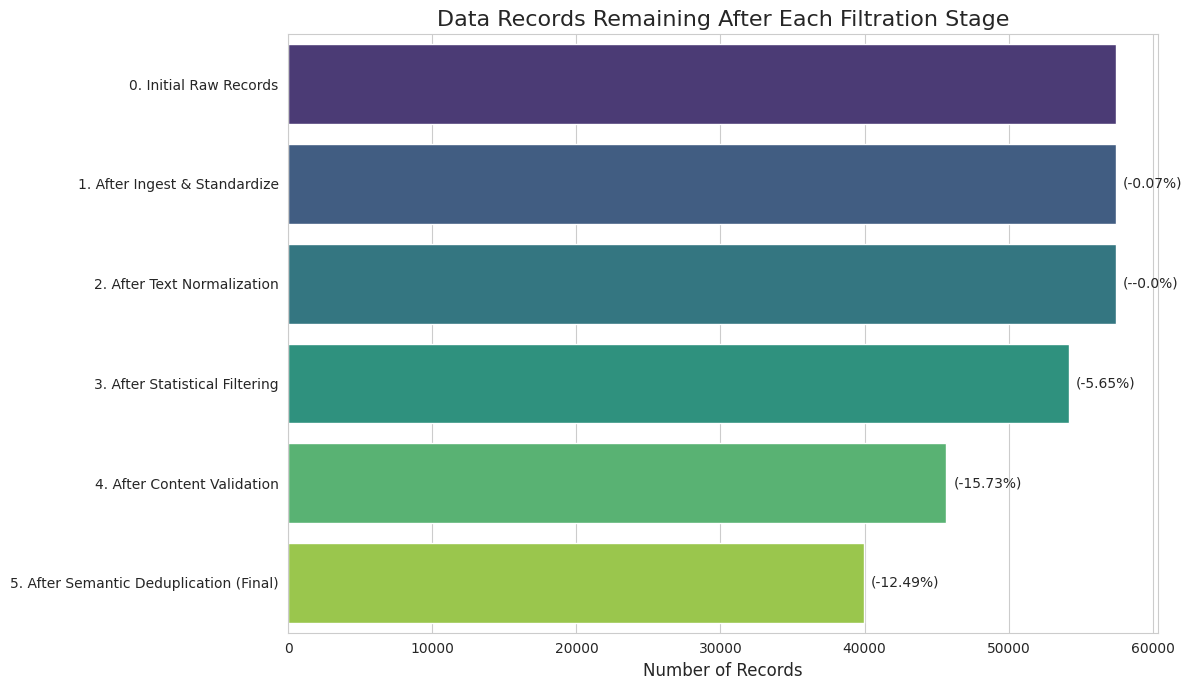

In [ ]:
# ==============================================================================
# 0. SETUP & INSTALLATIONS
# ==============================================================================
# INSTRUCTIONS:
# 1. Ensure you have a `requirements.txt` file in the project root.
# 2. Run `pip install -r requirements.txt` in your terminal to install all dependencies.
# 3. This notebook assumes the following project structure:
#
# AI-Adjudicator/
# ├── data/
# │   └── sample_dataset.csv
# ├── notebooks/
# │   └── 1-Phase1_DataFoundation_and_Governance.ipynb  <-- THIS FILE
# ├── output/
# │   ├── pipeline_checkpoints/
# │   └── high_purity_golden_datasets/
# └── requirements.txt
#
print("--- [0] Importing necessary libraries ---")

import os
import json
import re
import pandas as pd
import numpy as np
import pandera as pa
from pandera.errors import SchemaErrors
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from bs4 import BeautifulSoup, MarkupResemblesLocatorWarning
import ftfy
from langdetect import detect, DetectorFactory
from sentence_transformers import SentenceTransformer, util
from tqdm.auto import tqdm
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import warnings

# Suppress the BeautifulSoup warning for cleaner output
warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning)

# Ensure reproducibility for langdetect and download NLTK data
DetectorFactory.seed = 0
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)

print("\nLibraries imported successfully.")

# ==============================================================================
# 1. CONFIGURATION & PORTABLE PATHS
# ==============================================================================
print("\n--- [1] Setting up configuration and relative paths ---")

# Use relative paths to make the project portable
ROOT_DIR = '..' # Go up one level from the 'notebooks' directory
DATA_DIR = os.path.join(ROOT_DIR, 'data')
OUTPUT_DIR = os.path.join(ROOT_DIR, 'output') # All outputs will be saved here

# Define input and output paths
RAW_DATASET_PATH = os.path.join(DATA_DIR, 'sample_dataset.csv') # Reads from a sample for reproducibility
CHECKPOINT_DIR = os.path.join(OUTPUT_DIR, 'pipeline_checkpoints/')
GOLDEN_DATA_DIR = os.path.join(OUTPUT_DIR, 'high_purity_golden_datasets/')

# Create output directories if they don't exist
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(GOLDEN_DATA_DIR, exist_ok=True)

print(f"Reading sample data from: {RAW_DATASET_PATH}")
print(f"Checkpoints will be saved to: {CHECKPOINT_DIR}")
print(f"Final golden datasets will be saved to: {GOLDEN_DATA_DIR}")

# Define checkpoint file paths using the new structure
CHECKPOINT_PATHS = {
    'ingested': os.path.join(CHECKPOINT_DIR, '0_ingested.parquet'),
    'cleaned': os.path.join(CHECKPOINT_DIR, '1_cleaned.parquet'),
    'statistical_filtered': os.path.join(CHECKPOINT_DIR, '2_statistical_filtered.parquet'),
    'content_validated': os.path.join(CHECKPOINT_DIR, '3_content_validated.parquet'),
    'deduplicated': os.path.join(CHECKPOINT_DIR, '4_deduplicated.parquet'),
}

# ==============================================================================
# 2. MODULAR PIPELINE STEPS & DATA CONTRACT
# ==============================================================================
print("\n--- [2] Defining Modular Pipeline Steps & Data Contract ---")

# --- Data Schema Contract (Pandera) ---
final_schema = pa.DataFrameSchema({
    "id": pa.Column(str, unique=True, nullable=False),
    "prompt": pa.Column(str, checks=pa.Check(lambda s: s.str.len() >= 1)),
    "response_a": pa.Column(str, checks=pa.Check(lambda s: s.str.len() >= 1)),
    "response_b": pa.Column(str, checks=pa.Check(lambda s: s.str.len() >= 1)),
    "winner": pa.Column(str, checks=pa.Check.isin(['model_a', 'model_b', 'tie'])),
}, strict=True, ordered=True)
print("Pandera schema defined.")

# --- Cleaning and Filtration Functions (Unchanged logic) ---
def clean_and_normalize_text(text):
    text = ftfy.fix_text(str(text))
    text = BeautifulSoup(text, "lxml").get_text()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

english_stopwords = set(stopwords.words('english'))
def is_valid_content(text):
    if not isinstance(text, str) or len(text) < 15: return False
    try:
        if detect(text) != 'en': return False
    except: return False
    tokens = word_tokenize(text.lower())
    if not tokens: return False
    if (sum(1 for char in text if char in '.,!?;:"()[]{}') / len(text)) > 0.4: return False
    if (sum(1 for token in tokens if token in english_stopwords) / len(tokens)) > 0.8 and len(tokens) < 20: return False
    pos_tags = [tag for _, tag in nltk.pos_tag(tokens)]
    return any(tag.startswith('NN') for tag in pos_tags) and any(tag.startswith('VB') for tag in pos_tags)

def find_semantic_duplicates(prompts, model, threshold=0.95):
    print(f"Finding semantic duplicates in {len(prompts)} prompts...")
    embeddings = model.encode(prompts, convert_to_tensor=True, show_progress_bar=True)
    duplicates = util.paraphrase_mining(embeddings, top_k=1, score_threshold=threshold)
    duplicate_indices = {j for _, _, j in duplicates}
    print(f"Found {len(duplicate_indices)} semantic duplicates above threshold {threshold}.")
    return duplicate_indices

# --- Modular Pipeline Steps ---
def step_0_ingest_and_standardize(raw_filepath):
    print("--- Running Step 0: Ingest & Standardize ---")
    df = pd.read_csv(raw_filepath)
    df['id'] = df['id'].astype(str) # Standardize ID to string
    print(f"Loaded {len(df)} raw records.")
    df.drop_duplicates(subset=['id'], inplace=True)
    df.dropna(inplace=True)

    def parse_json_field(text):
        try: return json.loads(text)[0]
        except: return str(text)

    for col in ['prompt', 'response_a', 'response_b']:
        df[col] = df[col].apply(parse_json_field)
    
    # Check for winner columns and create a unified 'winner' column
    if all(c in df.columns for c in ['winner_model_a', 'winner_model_b', 'winner_tie']):
        conditions = [df['winner_model_a'] == 1, df['winner_model_b'] == 1, df['winner_tie'] == 1]
        choices = ['model_a', 'model_b', 'tie']
        df['winner'] = np.select(conditions, choices, default=None)
    
    df = df[['id', 'prompt', 'response_a', 'response_b', 'winner']].dropna()
    print(f"-> Remaining records: {len(df)}")
    return df

def step_1_clean_and_normalize(df):
    print("--- Running Step 1: Text Cleaning & Normalization ---")
    for col in ['prompt', 'response_a', 'response_b']:
        df[col] = df[col].apply(clean_and_normalize_text)
    print(f"-> Remaining records: {len(df)}")
    return df

def step_2_statistical_filter(df):
    print("--- Running Step 2: Statistical & Heuristic Filtering ---")
    for col in ['prompt', 'response_a', 'response_b']:
        low, high = df[col].str.len().quantile([0.01, 0.99])
        df = df[df[col].str.len().between(low, high)]
    print(f"-> Remaining records: {len(df)}")
    return df

def step_3_content_validation(df):
    print("--- Running Step 3: Language & Content Validation ---")
    for col in ['prompt', 'response_a', 'response_b']:
        mask = df[col].apply(is_valid_content)
        df = df[mask]
    print(f"-> Remaining records: {len(df)}")
    return df

def step_4_semantic_deduplication(df, threshold=0.95):
    print("--- Running Step 4: Semantic Deduplication ---")
    similarity_model = SentenceTransformer('all-MiniLM-L6-v2')
    prompts = df['prompt'].tolist()
    duplicate_indices_to_drop = find_semantic_duplicates(prompts, similarity_model, threshold=threshold)
    original_indices_to_drop = df.iloc[list(duplicate_indices_to_drop)].index
    df.drop(original_indices_to_drop, inplace=True)
    print(f"-> Remaining records: {len(df)}")
    return df

# ==============================================================================
# 3. PIPELINE ORCHESTRATOR
# ==============================================================================
print("\n--- [3] Defining Pipeline Orchestrator ---")
def run_pipeline_step(step_name, function, *args, force_rerun=False):
    checkpoint_path = CHECKPOINT_PATHS[step_name]
    if os.path.exists(checkpoint_path) and not force_rerun:
        print(f"Loading from checkpoint: {checkpoint_path}")
        return pd.read_parquet(checkpoint_path)
    else:
        df = function(*args)
        df.to_parquet(checkpoint_path, index=False)
        print(f"Saved checkpoint: {checkpoint_path}")
        return df

# ==============================================================================
# 4. EXECUTE PIPELINE & GENERATE REPORT
# ==============================================================================
print("\n--- [4] Executing the Full Pipeline ---")

# To rerun the entire pipeline from scratch, change to True
FORCE_RERUN_ALL = False
pipeline_state = {}
report = {}

report['initial_row_count'] = len(pd.read_csv(RAW_DATASET_PATH))
pipeline_state['ingested'] = run_pipeline_step('ingested', step_0_ingest_and_standardize, RAW_DATASET_PATH, force_rerun=FORCE_RERUN_ALL)
report['rows_after_ingest'] = len(pipeline_state['ingested'])

pipeline_state['cleaned'] = run_pipeline_step('cleaned', step_1_clean_and_normalize, pipeline_state['ingested'], force_rerun=FORCE_RERUN_ALL)
report['rows_after_cleaning'] = len(pipeline_state['cleaned'])

pipeline_state['statistical_filtered'] = run_pipeline_step('statistical_filtered', step_2_statistical_filter, pipeline_state['cleaned'], force_rerun=FORCE_RERUN_ALL)
report['rows_after_statistical_filter'] = len(pipeline_state['statistical_filtered'])

pipeline_state['content_validated'] = run_pipeline_step('content_validated', step_3_content_validation, pipeline_state['statistical_filtered'], force_rerun=FORCE_RERUN_ALL)
report['rows_after_content_validation'] = len(pipeline_state['content_validated'])

pipeline_state['deduplicated'] = run_pipeline_step('deduplicated', step_4_semantic_deduplication, pipeline_state['content_validated'], force_rerun=FORCE_RERUN_ALL)
report['rows_after_deduplication'] = len(pipeline_state['deduplicated'])

# --- Final Validation & Persistence ---
print("\n--- Final Validation & Persistence ---")
final_df = pipeline_state['deduplicated']

try:
    final_schema.validate(final_df)
    print("✅ Final validation successful!")
    timestamp = datetime.now().strftime('%Y-%m-%dT%H-%M-%S')
    filename = f'high_purity_golden_data_v_{timestamp}.parquet'
    filepath = os.path.join(GOLDEN_DATA_DIR, filename)
    final_df.to_parquet(filepath, index=False)
    print(f"\nSuccessfully wrote {len(final_df)} high-purity records to: {filepath}")

    # --- Reporting ---
    print("\n" + "="*60)
    print("      High-Purity Data Foundation Report")
    print("="*60)
    retention_rate = (len(final_df) / report['initial_row_count']) * 100
    print(f"      Overall Data Retention Rate: {retention_rate:.2f}%\n")
    report_data = {
        "Filtration Stage": [
            "0. Initial Raw Records", "1. After Ingest & Standardize", "2. After Text Normalization",
            "3. After Statistical Filtering", "4. After Content Validation", "5. After Semantic Deduplication (Final)",
        ],
        "Remaining Records": [
            report['initial_row_count'], report['rows_after_ingest'], report['rows_after_cleaning'],
            report['rows_after_statistical_filter'], report['rows_after_content_validation'], report['rows_after_deduplication'],
        ]
    }
    report_df = pd.DataFrame(report_data)
    report_df['% Dropped from Previous'] = -(report_df['Remaining Records'].pct_change() * 100).fillna(0).round(2)
    print(report_df.to_string(index=False))
    print("="*60)

    # --- Visualization ---
    plt.figure(figsize=(12, 7))
    sns.set_style("whitegrid")
    # FIX: Assign y to hue to avoid FutureWarning
    ax = sns.barplot(x="Remaining Records", y="Filtration Stage", data=report_df, orient='h', palette='viridis', hue="Filtration Stage", legend=False)
    plt.title('Data Records Remaining After Each Filtration Stage', fontsize=16)
    plt.xlabel('Number of Records', fontsize=12); plt.ylabel('')
    for i, p in enumerate(ax.patches):
        width = p.get_width()
        pct_dropped = report_df.iloc[i]['% Dropped from Previous']
        if i > 0: ax.text(width + 500, p.get_y() + p.get_height() / 2, f'(-{pct_dropped}%)', va='center')
    plt.tight_layout()
    plt.show()

except SchemaErrors as err:
    print("\n❌ FINAL VALIDATION FAILED! The final DataFrame does not conform to the schema.")
    print(err)